# Counterfactuals guided by prototypes on MNIST

This method can generate counterfactual instances guided by class prototypes. It means that for a certain instance X, the method builds a prototype for each prediction class using either an [auto-encoder](https://en.wikipedia.org/wiki/Autoencoder) or [k-d trees](https://en.wikipedia.org/wiki/K-d_tree). The nearest prototype class other than the originally predicted class is then used to guide the counterfactual search. For example, in MNIST the closest class to a 7 would be a 9. As a result, the prototype loss term will try to minimize the distance between the proposed counterfactual and the prototype of a 9. This speeds up the search towards a satisfactory counterfactual by steering it towards an interpretable solution from the start of the optimization. It also helps to avoid out-of-distribution counterfactuals with the perturbations driven to a prototype of another class.

The loss function to be optimized is the following: 

$Loss$ = c$L_{pred}$ + $\beta$$L_{1}$ + $L_{2}$ + $\gamma$$L_{AE}$ + $\theta$$L_{proto}$

The first loss term relates to the model's prediction function, the following 2 terms define the elastic net regularization while the last 2 terms are optional. The aim of $\gamma$$L_{AE}$ is to penalize out-of-distribution counterfactuals while $\theta$$L_{proto}$ guides the counterfactual to a prototype. When we only have acces to the model's predict function and cannot fully enjoy the benefits of automatic differentiation, the prototypes allow us to drop the predict function loss term and still generate reasonable counterfactuals. This drastically reduces the number of predict calls made during the numerical gradient update step and again speeds up the search.

Other options include generating counterfactuals for specific classes or including trust score constraints to ensure that the counterfactual is close enough to the newly predicted class compared to the original class. 

The different use cases highlighted above are illustrated throughout this notebook.

In [1]:
import keras
from keras import backend as K
from keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D, Input, UpSampling2D
from keras.models import Model, load_model
from keras.utils import to_categorical
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from time import time
from alibi.explainers import CounterFactualProto

Using TensorFlow backend.


## Load and prepare MNIST data

x_train shape: (60000, 28, 28) y_train shape: (60000,)


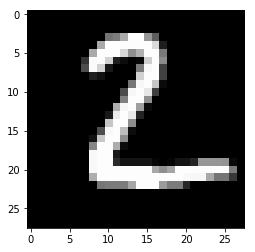

In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
print('x_train shape:', x_train.shape, 'y_train shape:', y_train.shape)
plt.gray()
plt.imshow(x_test[1])

Prepare data: scale, reshape and categorize

In [3]:
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
x_train = np.reshape(x_train, x_train.shape + (1,))
x_test = np.reshape(x_test, x_test.shape + (1,))
print('x_train shape:', x_train.shape, 'x_test shape:', x_test.shape)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
print('y_train shape:', y_train.shape, 'y_test shape:', y_test.shape)

x_train shape: (60000, 28, 28, 1) x_test shape: (10000, 28, 28, 1)
y_train shape: (60000, 10) y_test shape: (10000, 10)


In [4]:
xmin, xmax = -.5, .5
x_train = ((x_train - x_train.min()) / (x_train.max() - x_train.min())) * (xmax - xmin) + xmin
x_test = ((x_test - x_test.min()) / (x_test.max() - x_test.min())) * (xmax - xmin) + xmin

## Define and train CNN model

In [5]:
def cnn_model():
    x_in = Input(shape=(28, 28, 1))
    x = Conv2D(filters=64, kernel_size=2, padding='same', activation='relu')(x_in)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.3)(x)
    
    x = Conv2D(filters=32, kernel_size=2, padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.3)(x)
    
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x_out = Dense(10, activation='softmax')(x)
    
    cnn = Model(inputs=x_in, outputs=x_out)
    cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return cnn

In [6]:
cnn = cnn_model()
cnn.summary()
cnn.fit(x_train, y_train, batch_size=64, epochs=3, verbose=1)
cnn.save('mnist_cnn.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 32)        8224      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 7, 32)          0         
__________

Evaluate the model on test set

In [7]:
score = cnn.evaluate(x_test, y_test, verbose=0)
print('Test accuracy: ', score[1])

Test accuracy:  0.9862


## Define and train auto-encoder

In [8]:
def ae_model():
    # encoder
    x_in = Input(shape=(28, 28, 1))
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x_in)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    encoded = Conv2D(1, (3, 3), activation=None, padding='same')(x)
    encoder = Model(x_in, encoded)
    
    # decoder
    dec_in = Input(shape=(14, 14, 1))
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(dec_in)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    decoded = Conv2D(1, (3, 3), activation=None, padding='same')(x)
    decoder = Model(dec_in, decoded)
    
    # autoencoder = encoder + decoder
    x_out = decoder(encoder(x_in))
    autoencoder = Model(x_in, x_out)
    autoencoder.compile(optimizer='adam', loss='mse')
    
    return autoencoder, encoder, decoder

In [9]:
ae, enc, dec = ae_model()
ae.summary()
ae.fit(x_train, x_train, batch_size=128, epochs=4, validation_data=(x_test, x_test), verbose=1)
ae.save('mnist_ae.h5')
enc.save('mnist_enc.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
model_1 (Model)              (None, 14, 14, 1)         2625      
_________________________________________________________________
model_2 (Model)              (None, 28, 28, 1)         2625      
Total params: 5,250
Trainable params: 5,250
Non-trainable params: 0
_________________________________________________________________


/home/avl/anaconda3/envs/alibi/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Compare original with decoded images

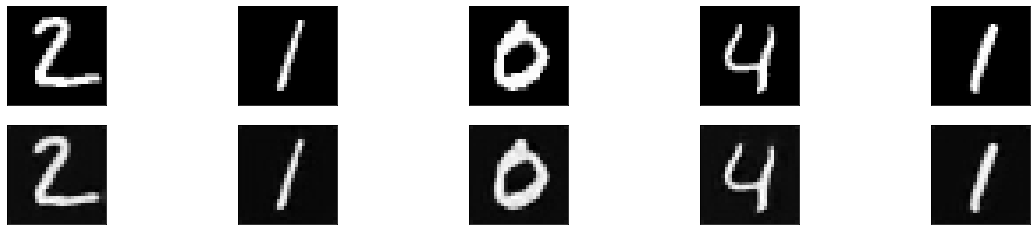

In [10]:
decoded_imgs = ae.predict(x_test)
n = 5
plt.figure(figsize=(20, 4))
for i in range(1, n+1):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i].reshape(28, 28))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Generate counterfactual guided by the nearest class prototype

Original instance:

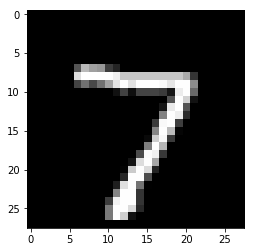

In [11]:
X = x_test[0].reshape((1,) + x_test[0].shape)
plt.imshow(X.reshape(28, 28))

Counterfactual parameters:

In [12]:
shape = (1,) + x_train.shape[1:]
gamma = 100.
theta = 100.
c_init = 1.
c_steps = 2
max_iterations = 500
feature_range = (x_train.min(),x_train.max())

Run counterfactual:

In [13]:
# set random seed
np.random.seed(1)
tf.set_random_seed(1)

# define models
cnn = load_model('mnist_cnn.h5')
ae = load_model('mnist_ae.h5')
enc = load_model('mnist_enc.h5')

sess = K.get_session()

# initialize explainer, fit and generate counterfactual
cf = CounterFactualProto(sess, cnn, shape, gamma=gamma, theta=theta,
                         ae_model=ae, enc_model=enc, max_iterations=max_iterations,
                         feature_range=feature_range, c_init=c_init, c_steps=c_steps)
start_time = time()
cf.fit(x_train)  # find class prototypes
print('Time to find prototypes each class: {:.3f} sec'.format(time() - start_time))
start_time = time()
explanation = cf.explain(X)
print('Explanation took {:.3f} sec'.format(time() - start_time))

sess.close()
K.clear_session()

Time to find prototypes each class: 16.354 sec
Explanation took 4.252 sec


Results:

Counterfactual prediction: 9
Closest prototype class: 9


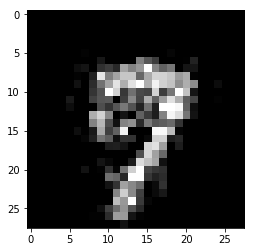

In [14]:
print('Counterfactual prediction: {}'.format(explanation['cf']['class']))
print('Closest prototype class: {}'.format(cf.id_proto))
plt.imshow(explanation['cf']['X'].reshape(28, 28))

The counterfactual starting from a 7 moves towards its closest prototype class: a 9. The evolution of the counterfactual during the first iteration can be seen below:

iteration c 0


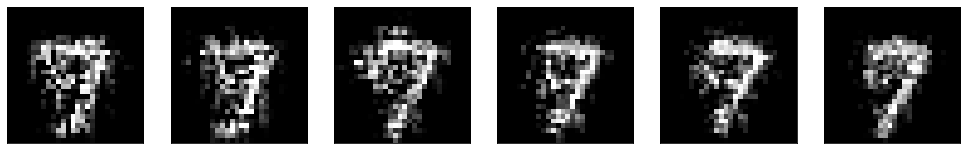

In [15]:
iter_cf = 0
print('iteration c {}'.format(iter_cf))
n = len(explanation['all'][iter_cf])
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(1, n+1, i+1)
    plt.imshow(explanation['all'][iter_cf][i].reshape(28, 28))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Typically, the first few iterations already steer the 7 towards a 9, while the later iterations make the counterfactual more sparse.

## Remove the auto-encoder loss term

In the previous example, we used both an auto-encoder loss term to penalize a counterfactual which falls outside of the training data distribution as well as an encoder loss term to guide the counterfactual to the nearest prototype class. In the next example we get rid of the auto-encoder loss term to speed up the counterfactual search and still get decent results:

In [16]:
theta = 500.

In [17]:
# set random seed
np.random.seed(1)
tf.set_random_seed(1)

# define models
cnn = load_model('mnist_cnn.h5')
enc = load_model('mnist_enc.h5')

sess = K.get_session()

# initialize explainer, fit and generate counterfactual
cf = CounterFactualProto(sess, cnn, shape, theta=theta,
                         enc_model=enc, max_iterations=max_iterations,
                         feature_range=feature_range, c_init=c_init, c_steps=c_steps)
cf.fit(x_train)
start_time = time()
explanation = cf.explain(X)
print('Explanation took {:.3f} sec'.format(time() - start_time))

sess.close()
K.clear_session()

Explanation took 2.877 sec


Results:

Counterfactual prediction: 9
Closest prototype class: 9


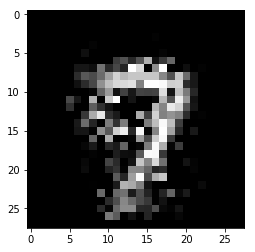

In [18]:
print('Counterfactual prediction: {}'.format(explanation['cf']['class']))
print('Closest prototype class: {}'.format(cf.id_proto))
plt.imshow(explanation['cf']['X'].reshape(28, 28))

## Add trust scores

Explainability through counterfactuals can involve a trade off between sparsity and interpretability. The first counterfactual below is sparse and flips the original 7 into a 3. It is obtained by setting the auto-encoder and prototype loss terms to 0, moving the objective function towards an elastic net regularizer which generates sparse solutions. It is clear however that this is not a very interpretable 3 which lies very far from its class prototype or the training data distribution:

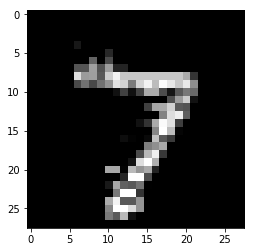

Class 3 prototype:

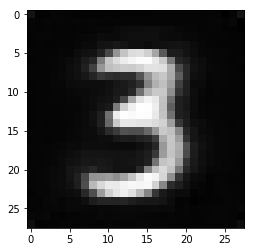

By adding in the nearest prototype and auto-encoder loss terms, the counterfactual becomes more interpretable but less sparse. The example below illustrates this by flipping the same 7 into a 9:

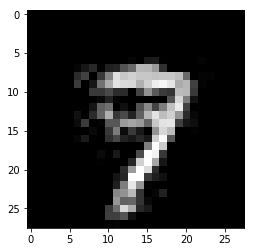

Class 9 prototype:

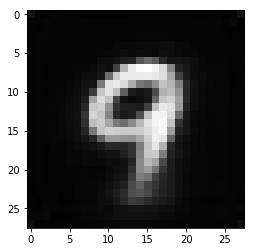

In order to help interpretability, we can add a trust score constraint on the proposed counterfactual. The trust score is defined as the ratio of the distance between the encoded counterfactual and the prototype of the class predicted on the original instance, and the distance between the encoded counterfactual and the prototype of the class predicted for the counterfactual instance. Intuitively, a high trust score implies that the counterfactual is far from the originally predicted class compared to the counterfactual class. For more info on trust scores, please check out the [documentation](../methods/TrustScores.ipynb). The example below shows the impact of such a trust score constraint:

In [19]:
theta = 100.
c_init = 1.
c_steps = 5

In [24]:
# set random seed
np.random.seed(1)
tf.set_random_seed(1)

# define models
cnn = load_model('mnist_cnn.h5')
enc = load_model('mnist_enc.h5')

sess = K.get_session()

# initialize explainer, fit and generate counterfactual
cf = CounterFactualProto(sess, cnn, shape, theta=theta,
                         enc_model=enc, max_iterations=max_iterations,
                         feature_range=feature_range, c_init=c_init, c_steps=c_steps)
cf.fit(x_train)  # find class prototypes
explanation1 = cf.explain(X, threshold=0.)
explanation2 = cf.explain(X, threshold=.8)

sess.close()
K.clear_session()

Original instance:

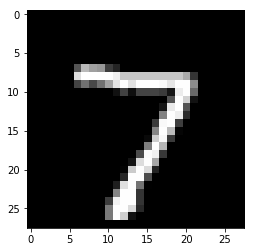

In [25]:
plt.imshow(X.reshape(28, 28))

The counterfactual below without the trust score threshold predicts a 3 which actually starts to look like a 9 since that is the nearest prototype class. This counterfactual is slightly sparser than the second counterfactual below which has the trust score threshold at 0.8. The sparser counterfactual does not meet this trust score constraint and is therefore rejected in the second example. 

Counterfactual prediction: 3
Closest prototype class: 9


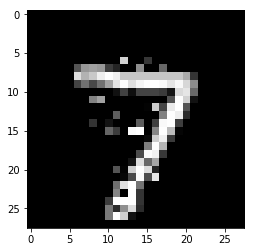

In [26]:
print('Counterfactual prediction: {}'.format(explanation1['cf']['class']))
print('Closest prototype class: {}'.format(cf.id_proto))
plt.imshow(explanation1['cf']['X'].reshape(28, 28))

Counterfactual prediction: 9
Closest prototype class: 9


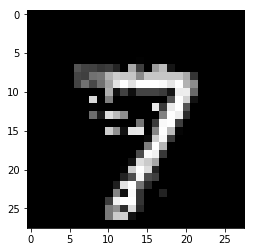

In [27]:
print('Counterfactual prediction: {}'.format(explanation2['cf']['class']))
print('Closest prototype class: {}'.format(cf.id_proto))
plt.imshow(explanation2['cf']['X'].reshape(28, 28))

## Specify prototype classes

For multi-class predictions, we might be interested to generate counterfactuals for certain classes while avoiding others. The following example illustrates how to do this. It does not guarantee that the avoided classes are excluded from the counterfactuals, but does not include those classes when looking for the nearest prototype class. So as a result, it will not drive the counterfactual to the prototype of the classes that should be avoided.

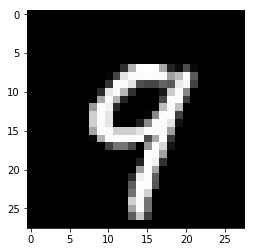

In [28]:
X = x_test[12].reshape((1,) + x_test[1].shape)
plt.imshow(X.reshape(28, 28))

In [29]:
theta = 100.
gamma = 100.
c_init = 1.
c_steps = 3
max_iterations = 1000

In [30]:
# set random seed
np.random.seed(1)
tf.set_random_seed(1)

# define models
cnn = load_model('mnist_cnn.h5')
ae = load_model('mnist_ae.h5')
enc = load_model('mnist_enc.h5')

sess = K.get_session()

# initialize explainer, fit and generate counterfactual
cf = CounterFactualProto(sess, cnn, shape, gamma=gamma, theta=theta,
                         ae_model=ae, enc_model=enc, max_iterations=max_iterations,
                         feature_range=feature_range, c_init=c_init, c_steps=c_steps)
cf.fit(x_train)  # find class prototypes
explanation1 = cf.explain(X)
proto_class1 = cf.id_proto
explanation2 = cf.explain(X, target_class=[7])
proto_class2 = cf.id_proto

sess.close()
K.clear_session()

The closest class to a 9 is 4. This is evident by looking at the first counterfactual below. For the second counterfactual, we specified that the prototype class used in the search should be a 7. As a result, the 9 is not pushed towards a 4.

Counterfactual prediction: 4
Closest prototype class: 4


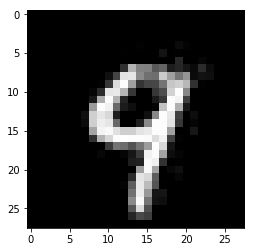

In [31]:
print('Counterfactual prediction: {}'.format(explanation1['cf']['class']))
print('Closest prototype class: {}'.format(proto_class1))
plt.imshow(explanation1['cf']['X'].reshape(28, 28))

While the counterfactual still looks like a 9 at first sight, it is clear by looking at the difference plot between the counterfactual and the original instance that the pixels generating the circle of the 9 are being removed, moving towards a 7.

Counterfactual prediction: 7
Closest prototype class: 7


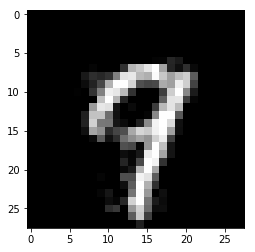

In [32]:
print('Counterfactual prediction: {}'.format(explanation2['cf']['class']))
print('Closest prototype class: {}'.format(proto_class2))
plt.imshow(explanation2['cf']['X'].reshape(28, 28))

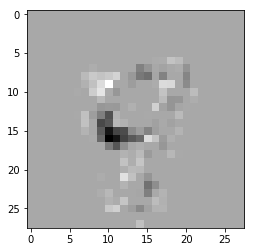

In [33]:
plt.imshow((explanation2['cf']['X'] - X).reshape(28, 28))

## Speed up the counterfactual search by removing the predict function loss term

We can also remove the prediction loss term and still obtain an interpretable counterfactual. This is especially relevant for fully black box models. When we provide the counterfactual search method with a Keras or TensorFlow model, it is incorporated in the TensorFlow graph and evaluated using automatic differentiation. However, if we only have access to the model's predict function, the gradient updates are numerical and typically require a large number of prediction calls because of the predict loss term. These prediction calls can slow the search down significantly and become a bottleneck. We can represent the gradient of the loss term as follows:

\begin{equation*} \frac{\partial L_{pred}}{\partial x} = \frac{\partial L_{pred}}{\partial p} \frac{\partial p}{\partial x} \end{equation*}

where $L_{pred}$ is the prediction loss term, $p$ the predict function and $x$ the input features to optimize. For a 28 by 28 MNIST image, the $^{\delta p}/_{\delta x}$ term alone would require a prediction call with batch size 28x28x2 = 1568. By using the prototypes to guide the search however, we can remove the prediction loss term and only make a single prediction at the end of each gradient update to check whether the predicted class on the proposed counterfactual is different from the original class. We do not necessarily need a Keras or TensorFlow auto-encoder either and can use k-d trees to find the nearest class prototypes. Please check out [this notebook](./cfproto_housing.ipynb) for a practical example.

We'll first illustrate this method by using a Keras model and then try a black box model.

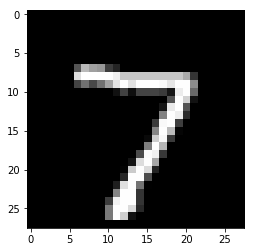

In [34]:
X = x_test[0].reshape((1,) + x_test[0].shape)
plt.imshow(X.reshape(28, 28))

In [35]:
c_init = 0.  # set weight predict loss term to 0
c_steps = 1  # do not update c further
max_iterations = 2000
theta = 100.
gamma = 100.

In [36]:
# set random seed
np.random.seed(1)
tf.set_random_seed(1)

# define models
cnn = load_model('mnist_cnn.h5')
ae = load_model('mnist_ae.h5')
enc = load_model('mnist_enc.h5')

sess = K.get_session()

# initialize explainer, fit and generate counterfactual
cf = CounterFactualProto(sess, cnn, shape, gamma=gamma, theta=theta,
                         ae_model=ae, enc_model=enc, max_iterations=max_iterations,
                         feature_range=feature_range, c_init=c_init, c_steps=c_steps)
cf.fit(x_train)  # find class prototypes
explanation = cf.explain(X)

sess.close()
K.clear_session()

Still get a reasonable 9:

Counterfactual prediction: 9
Closest prototype class: 9


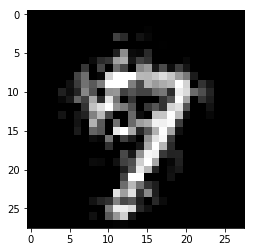

In [37]:
print('Counterfactual prediction: {}'.format(explanation['cf']['class']))
print('Closest prototype class: {}'.format(cf.id_proto))
plt.imshow(explanation['cf']['X'].reshape(28, 28))

Let us now use the black box model:

In [38]:
# set random seed
np.random.seed(1)
tf.set_random_seed(1)

# define models
cnn = load_model('mnist_cnn.h5')
predict_fn = lambda x: cnn.predict(x)
ae = load_model('mnist_ae.h5')
enc = load_model('mnist_enc.h5')

sess = K.get_session()

# initialize explainer, fit and generate counterfactual
cf = CounterFactualProto(sess, predict_fn, shape, gamma=gamma, theta=theta,
                         ae_model=ae, enc_model=enc, max_iterations=max_iterations,
                         feature_range=feature_range, c_init=c_init, c_steps=c_steps)
cf.fit(x_train)  # find class prototypes
start_time = time()
explanation = cf.explain(X)
print('Explanation took {:.3f} sec'.format(time() - start_time))

sess.close()
K.clear_session()

Explanation took 8.979 sec


Which again gives a 9 as counterfactual:

Counterfactual prediction: 9
Closest prototype class: 9


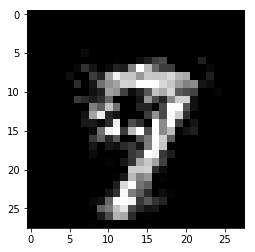

In [39]:
print('Counterfactual prediction: {}'.format(explanation['cf']['class']))
print('Closest prototype class: {}'.format(cf.id_proto))
plt.imshow(explanation['cf']['X'].reshape(28, 28))

We can include the prediction loss term again and compare the explanation time for the same amount of iteration steps:

In [40]:
c_init = 1.  # set weight predict loss term to 0
c_steps = 4  # do not update c further
max_iterations = 500  # 4x500 = 2000

In [41]:
# set random seed
np.random.seed(1)
tf.set_random_seed(1)

# define models
cnn = load_model('mnist_cnn.h5')
predict_fn = lambda x: cnn.predict(x)
ae = load_model('mnist_ae.h5')
enc = load_model('mnist_enc.h5')

sess = K.get_session()

# initialize explainer, fit and generate counterfactual
cf = CounterFactualProto(sess, predict_fn, shape, gamma=gamma, theta=theta,
                         ae_model=ae, enc_model=enc, max_iterations=max_iterations,
                         feature_range=feature_range, c_init=c_init, c_steps=c_steps)
cf.fit(x_train)  # find class prototypes
start_time = time()
explanation = cf.explain(X)
print('Explanation took {:.3f} sec'.format(time() - start_time))

sess.close()
K.clear_session()

Explanation took 893.747 sec


Counterfactual prediction: 9
Closest prototype class: 9


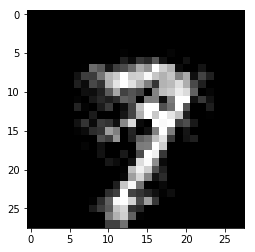

In [42]:
print('Counterfactual prediction: {}'.format(explanation['cf']['class']))
print('Closest prototype class: {}'.format(cf.id_proto))
plt.imshow(explanation['cf']['X'].reshape(28, 28))

By removing the predict loss term and having the nearest class prototype guide the counterfactual, we can speed up the search by about 100x for a simple CNN. Please note that these examples are not optimized for speed but just highlight the difference in performance.

Clean up:

In [43]:
os.remove('mnist_cnn.h5')
os.remove('mnist_ae.h5')
os.remove('mnist_enc.h5')